## MNIST Digit Generator with Convolutional VAE

Generating handwritten digits (0-9) similar to the digits in the MNIST dataset with a VAE model. This version of the VAE model uses convolutional layers in the encoder- and decoder neural networks. 

This notebook is similar to the simple_vae.ipynb notebook, but a deep convolutional neural networks are used to learn to generate the fake digits. 

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from models import ConvVAE, VAELoss

In [2]:
# Load and store the MNIST train data 
transform = transforms.Compose([
    torchvision.transforms.ToTensor(), 
    torchvision.transforms.Normalize((0.1307,), (0.3081,))
])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


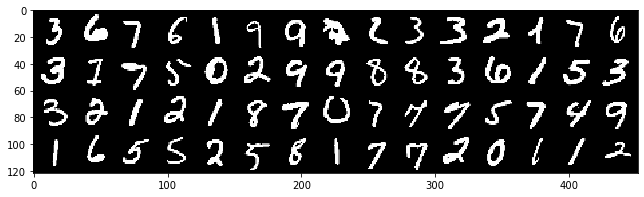

In [3]:
# Visualize some of the training data 
plt.figure(figsize=(15, 3))
digits, _ = next(iter(trainloader))
grid = torchvision.utils.make_grid(digits[0:60], nrow=15)
plt.imshow(grid.permute(1, 2, 0))
plt.show()

In [4]:
# Setup model, criterion, and optimizer
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

latent_size = 3

# For model and loss function details see 'models.py' file. 
model = ConvVAE(latent_size=latent_size).to(device)
criterion = VAELoss()
optimizer = optim.Adam(model.parameters(), lr=4e-4)

In [5]:
# Training the model on the dataset
epochs = 5
for e in range(epochs):
    running_loss = 0
    for (_, data) in enumerate(trainloader, 0):
        x, _ = data
        x = x.to(device)

        optimizer.zero_grad()
        x, x_hat, mu, logvar, _ = model(x)
        loss = criterion(x, x_hat, mu, logvar)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {e}: Loss {running_loss / len(trainloader)}")


Epoch 0: Loss 48641.95779296875
Epoch 1: Loss 40725.583170572914
Epoch 2: Loss 39036.11248697917
Epoch 3: Loss 38066.29693359375
Epoch 4: Loss 37404.821302083335


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


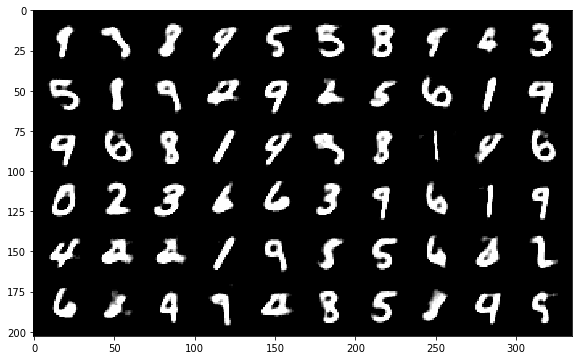

In [6]:
# setup z for decoder network input.
z_test = np.random.normal(size=(60, latent_size))
z_test = torch.from_numpy(z_test).float().to(device)

x_hat = model.decode(z_test)
# reshape into old image format 
x_hat = x_hat.view((-1, 1, 28, 28))

# create and visualize grid
grid = torchvision.utils.make_grid(x_hat, nrow=10, padding=5)
plt.figure(figsize=(15, 6))
plt.imshow(grid.permute(1, 2, 0).detach().cpu().numpy())
plt.show()

## Weighting the $D_{KL}$ loss term. 

Experiment with increasing the influence of the the $D_{KL}$ factor in the loss function by multiplying with factor $\beta$ (see $\beta$-VAE, Higgins et al. 2017). 

Experiments seem to produce slightly better than the standard version of the VAE. 

In [19]:
beta_model = ConvVAE(latent_size=latent_size).to(device)
criterion = VAELoss(beta=4.0)
optimizer = optim.Adam(beta_model.parameters(), lr=4e-4)

# Training the model on the dataset
for e in range(epochs):
    running_loss = 0
    for (_, data) in enumerate(trainloader, 0):
        x, _ = data
        x = x.to(device)

        optimizer.zero_grad()
        x, x_hat, mu, logvar, _ = beta_model(x)
        loss = criterion(x, x_hat, mu, logvar)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {e}: Loss {running_loss / len(trainloader)}")


Epoch 0: Loss 49542.98590494792
Epoch 1: Loss 43081.88393229167
Epoch 2: Loss 41625.29451171875
Epoch 3: Loss 40824.7966796875
Epoch 4: Loss 40285.06585286458


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


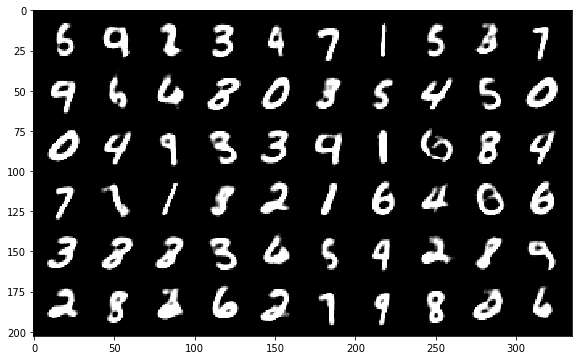

In [20]:
x_hat = beta_model.decode(z_test)
# reshape into old image format 
x_hat = x_hat.view((-1, 1, 28, 28))

# create and visualize grid
grid = torchvision.utils.make_grid(x_hat, nrow=10, padding=5)
plt.figure(figsize=(15, 6))
plt.imshow(grid.permute(1, 2, 0).detach().cpu().numpy())
plt.show()

In [23]:
# Save the model for later inference 
torch.save(beta_model.get_state_dict(), 'models/mnist_dc_vae.pt')

AttributeError: 'ConvVAE' object has no attribute 'get_state_dict'

### Visualizing the latent space. 

Visualizing and comparing the class distribution of the two learned models in the latent space.

In [21]:
loader = torch.utils.data.DataLoader(trainset, batch_size=1000, shuffle=True)
x, y = next(iter(loader))
x = x.to(device)
_, _, _, _, z = model(x)
_, _, _, _, z_beta = beta_model(x)

z = z.detach().cpu().numpy()
z_beta = z_beta.detach().cpu().numpy()
y = y.detach().cpu().numpy()

from sklearn import decomposition

pca = decomposition.PCA(n_components=2)
pca.fit(z)
x = pca.fit_transform(z)

print(f"Explained Variance (No Beta Model): {np.sum(pca.explained_variance_ratio_):.2f}") 

pca = decomposition.PCA(n_components=2)
pca.fit(z_beta)
x_beta = pca.fit_transform(z_beta)

print(f"Explained Variance (Beta Model): {np.sum(pca.explained_variance_ratio_):.2f}") 


Explained Variance (No Beta Model): 0.80
Explained Variance (Beta Model): 0.74


Visualizing the results in 2d scatter plot. Not sure this helps to entangle the ten classes better. 

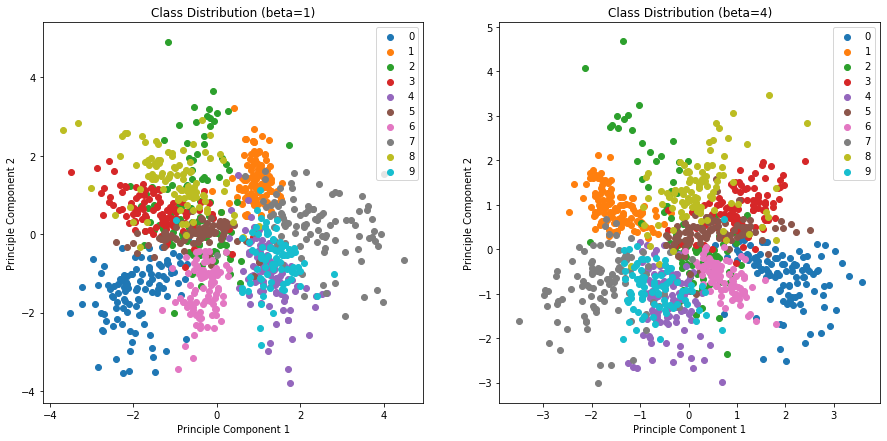

In [22]:
plt.figure(figsize=(15, 7))

plt.subplot(121)
scatter_x = x[:, 0]
scatter_y = x[:, 1]
# split for 9 classes
for c in np.unique(y):
    idx = np.where(y == c)
    plt.scatter(scatter_x[idx], scatter_y[idx])
    
plt.legend([str(i) for i in range(0, 10)])
plt.xlabel('Principle Component 1')
plt.ylabel('Principle Component 2')
plt.title('Class Distribution (beta=1)')

plt.subplot(122)
scatter_x = x_beta[:, 0]
scatter_y = x_beta[:, 1]
# split for 9 classes
for c in np.unique(y):
    idx = np.where(y == c)
    plt.scatter(scatter_x[idx], scatter_y[idx])
    
plt.legend([str(i) for i in range(0, 10)])
plt.xlabel('Principle Component 1')
plt.ylabel('Principle Component 2')
plt.title('Class Distribution (beta=4)')

plt.show()
